### Week 2 Problem Set: Graph Theory

In this exercise we will work with real data from the C. Elegans nervous system, using data shared by the [WormAtlas](http://www.wormatlas.org/) database.  We will treat it as an undirected connectome for the purposes of this exercise.

For some problems you will be provided with skeleton code - fill in the lines marked ```...``` with appropriate code to solve problem.

In [6]:
import pandas,numpy
import os,sys
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats

from brainnetworks.brainnetworks.utils import mk_random_graph

%matplotlib inline

# read the data from Wormatlas.org: see section 2.1 of http://www.wormatlas.org/neuronalwiring.html for details

celegans_connectome=pandas.read_excel('http://www.wormatlas.org/images/NeuronConnect.xls')

# set up the graph
Gd = nx.DiGraph()
for i in celegans_connectome.index:
    Gd.add_edge(celegans_connectome.loc[i]['Neuron 1'],celegans_connectome.loc[i]['Neuron 2'])
    
Gu=Gd.to_undirected()

# the graph has two connected components, so we will just keep the giant component
components=nx.connected_component_subgraphs(Gu)
G=next(components)


### Problem 1:

a. Plot a histogram of the degree distribution, and print out the mean and maximum degree


mean degree: 17.11743772241993
max degree: 115


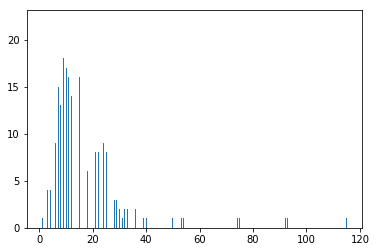

In [10]:
degree_vals=[G.degree[i] for i in G.nodes]
degree_dist=plt.hist(degree_vals,500)
print('mean degree:', numpy.mean(degree_vals))
print('max degree:',numpy.max(degree_vals))

b. Compute the average clustering coefficient for the connectome

In [11]:
ce_clustering = nx.average_clustering(G)
print(ce_clustering)

0.34604428028046025


c. Compute the average path length for the connectome

In [12]:
ce_avgpathlength = nx.average_shortest_path_length(G)
print(ce_avgpathlength)

2.324377224199288


#### Problem 2

First, use the provided code to create 100 random graphs with the same size as the C. Elegans connectome. For each graph, we compute its average clustering, average shortest path length, and maximum degree, and store those to a numpy array. (This may take a few minutes to run.)

In [32]:
# PROVIDED CODE
nruns=100
measures=['clustering','avgpathlength','maxdegree']
results=pandas.DataFrame(numpy.zeros((nruns,len(measures))),
                        columns=measures)

for i in range(nruns):
    G_rand = mk_random_graph(G)
    results.iloc[i]['clustering']=nx.average_clustering(G_rand)
    results.iloc[i]['avgpathlength']=nx.average_shortest_path_length(G_rand)
    results.iloc[i]['maxdegree']=numpy.max([G_rand.degree[i] for i in G_rand.nodes])
    

a.  Compute the tail probability of the observed values of cluster and path length for the C. elegans network, in comparison to the random network results.  That is, what is the probability of a value as or more extreme than the observed value wihtin the random graph distribution? You may find the function ```scipy.stats.percentileofscore()``` useful for this purpose.

In [30]:
### PROVIDED CODE: 

p_clustering=100-scipy.stats.percentileofscore(results.iloc[:,0],ce_clustering,kind='weak')
print('Observed:',ce_clustering,'Random:',results['clustering'].mean(),'P<',p_clustering)

p_avgpathlength=100-scipy.stats.percentileofscore(results.iloc[:,1],ce_avgpathlength,kind='weak')
print('Observed:',ce_avgpathlength,'Random:',results['avgpathlength'].mean(),'P<',p_avgpathlength)

p_maxdegree=100-scipy.stats.percentileofscore(results.iloc[:,1],numpy.max(degree_vals),kind='weak')
print('Observed:',numpy.max(degree_vals),'Random:',results['maxdegree'].mean(),'P<',p_maxdegree)


Observed: 0.34604428028046025 Random: 0.061353834769057 P< 0.0
Observed: 2.324377224199288 Random: 2.2692267412303 P< 0.0
Observed: 115 Random: 29.58 P< 0.0


Based on the results of this analysis, do you think that the C. Elegans connectome is a "small world" network"? explain your answer.

ANSWER: For all three of the parameters, the probability that the C. Elegans results came from a random graph is zero.  These results indicate the C.Elegans connectome is a small world network, and that is is not a random network.  The clusterinng coefficient is much higher than even the highest clustering coefficient in the random graphs (leading to the zero proability).  Similarly, while the C.Elegans avg shortest path lenght is closer to the avg shortest path length in the random graphs, it is still larger than the max avg path length from the random graphs (hence, the zero probability).  Additionally, the spread of degree values in the C.Elegans graph is much more skewed than that in the random graphs, further indicating that the C.Elegans is a small world network and not random.
    

### Problem 3:

Determine which neuron is the most important based on these four criteria:

- degree centrality
- betweenness centrality
- closeness centrality
- eigenvector centrality

Because networkx returns a dictionary when it computes centrality measures, we have provided a utility function to return the entry with the largest value.

In [25]:
### PROVIDED CODE

def get_max_from_dict(d):
    """
    return the dict entry with the max value
    after https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
    """
    return max(d, key=lambda key: d[key])

central_nodes={}
# compute degree centrality
central_nodes['degree']=get_max_from_dict(nx.degree_centrality(G))
# compute eigenvector centrality
central_nodes['eigenvector']=get_max_from_dict(nx.eigenvector_centrality(G))
# compute betweenness centrality
central_nodes['betweenness']=get_max_from_dict(nx.betweenness_centrality(G))
# compute closeness centrality
central_nodes['closeness']=get_max_from_dict(nx.closeness_centrality(G))

print(central_nodes)

{'degree': 'NMJ', 'eigenvector': 'AVAR', 'betweenness': 'NMJ', 'closeness': 'NMJ'}


You should see that the most central node differs between the different measures.  Given what you know about those measures, explain why this might be the case.

ANSWER: In the C.Elegans connectome, the most central node due to degree, betweeness, and closeness is NMJ, wheras the most central node due to eigenvector centrality is AVAR.  It makes sense that there is a difference in the central node as each type of centrality measures something different. Degree centrality measure how many nodes are one walk away from the node of interest, eigenvector centrality is similar to degreen centrality however the weights assigned to each node depend on the connectednes of the adjacent node.  Betweeness centrality measures how many shortest paths transverse a node, and closeness centrality measures the total distance from any vertex to all other vertices via the shortest path.  Therefore, it is possible for a nnode to have high centrality in one or more of the measures but not the others.  In the C.Elegans connectome, NMJ has high degree centrality (indicating the most edges), high betweeness centrality (indicating the most interconnected neighbors), and high closeness centrality, whereas it does not have the highest eignevector centrality (inicated that it is not connected to the most highly connected neighbors.  AVAR instead has the highest eigenvector centrality.  Additionally, while the different types of centrality are all measuring different things, they are correlated so it makes sense that some of the measures have the same node, but it this does not always have to be the case, as it is possble that the node could differ for all for measures.   

